In [1]:
%load_ext autoreload
%autoreload 2

from imports import *
from scipy.linalg import qr
from dppy.finite_dpps import FiniteDPP

np.random.seed(1)

### One of these things is not like the others

In [36]:
# img = mpl.image.imread('cartagena.jpg')
img = mpl.image.imread('parrots.png')

from skimage.color import rgb2gray                
gs_img = rgb2gray(img)

window_width = 25
keys, feats = utils.img_feature_extractor(img, window_width=window_width)

L = utils.gaussian_kernel(feats, s=np.median(np.linalg.norm(feats, axis=1)), exponent=2)
img_dpp = FiniteDPP('likelihood', **{'L': L})

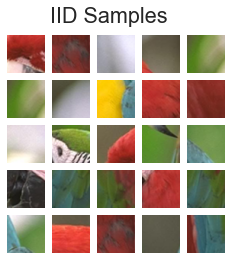

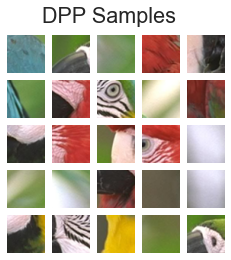

In [37]:
num_samples = 25
# window_width = 12

iid_sample, title = np.random.choice(len(keys), num_samples), 'IID Samples'
windows = utils.extract_window_at_locs(img, keys[iid_sample, ...], window_width=window_width)
utils.plot_img_grid(windows, figsize=(8, 4), title=title)
plt.show()

dpp_sample, title = img_dpp.sample_exact_k_dpp(num_samples), 'DPP Samples'
windows = utils.extract_window_at_locs(img, keys[dpp_sample, ...], window_width=window_width)
utils.plot_img_grid(windows, figsize=(8, 4), title=title)
plt.show()

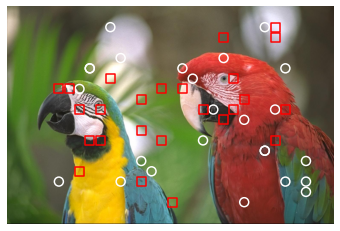

In [39]:
plt.imshow(img)
plt.scatter(keys[iid_sample, 1], keys[iid_sample, 0], marker='o', facecolors='none', edgecolors='white')
plt.scatter(keys[dpp_sample, 1], keys[dpp_sample, 0], marker='s', facecolors='none', edgecolors='red')
plt.axis('off')
plt.show()

### Variance Reduction

In [121]:
N, D = 500, 2
X = np.random.randn(N, D)
L = utils.gaussian_kernel(X, s=np.sqrt(D), exponent=2)# L = X @ X.T
dpp = FiniteDPP('likelihood', **{'L': L})

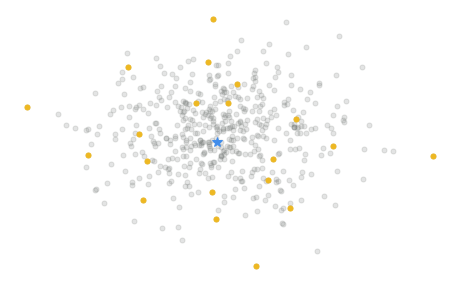

In [127]:
sample = dpp.sample_exact_k_dpp(20)
# sample = np.random.choice(N, 20)

est_mean = np.mean(X[sample, :], axis=0, keepdims=True)
plt.figure(figsize=(8, 5))
plt.plot(X[:, 0], X[:, 1], '.', markersize=10, c=CLR['dgray'], alpha=0.2)
plt.plot(X[sample, 0], X[sample, 1], '.', c=CLR['lgold'], markersize=10)
plt.plot(est_mean[:, 0], est_mean[:, 1], '*', c=CLR['blue'], markersize=10)
plt.axis('off')
plt.show()

In [129]:
num_trials = 200
dpp_exps = {}; iid_exps = {}
ns_list = [5, 10, 20, 30, 50, 75, 100]

for num_samples in ns_list:
    print('Num Samples ', num_samples)
    
    dpp = FiniteDPP('likelihood', **{'L': L})
    dpp_exp = utils.Experiment('dpp_'+str(num_samples))
    utils.run_mean_experiment(dpp_exp, X, dpp.sample_exact_k_dpp, num_samples, num_trials)
    dpp_exps[num_samples] = dpp_exp
    
    
    iid_exp = utils.Experiment('iid_'+str(num_samples))
    utils.run_mean_experiment(iid_exp, X, lambda u: np.random.choice(N, u), num_samples, num_trials)
    iid_exps[num_samples] = iid_exp

Num Samples  5
Num Samples  10
Num Samples  20
Num Samples  30
Num Samples  50
Num Samples  75
Num Samples  100


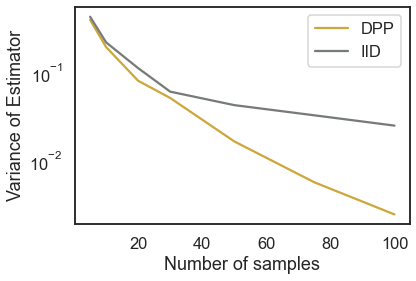

In [130]:
plt.plot(ns_list, [dpp_exps[_].storage['var'] for _ in ns_list], color=CLR['gold'], label='DPP')
plt.plot(ns_list, [iid_exps[_].storage['var'] for _ in ns_list], color=CLR['dgray'], label='IID')
plt.xlabel('Number of samples')
plt.ylabel('Variance of Estimator')
plt.semilogy()
plt.legend()
plt.show()

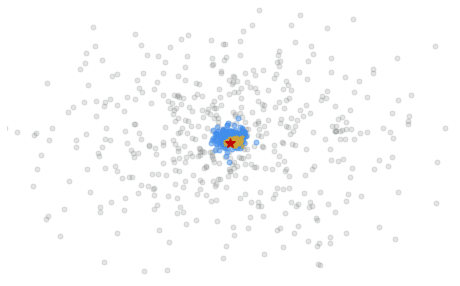

In [131]:
plt.figure(figsize=(8, 5))

plt.plot(X[:, 0], X[:, 1], '.', markersize=10, c=CLR['dgray'], alpha=0.2)

for mean in iid_exps[100].storage['array']:
    plt.plot(mean[:, 0], mean[:, 1], 'o', c=CLR['blue'], markersize=5, alpha=0.5)

for mean in dpp_exps[100].storage['array']:
    plt.plot(mean[:, 0], mean[:, 1], '*', c=CLR['gold'], markersize=5, alpha=0.7)

plt.plot(0, 0, '*', c=CLR['red'], markersize=10)

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)

plt.axis('off');

### Where did repulsion go?

In [132]:
N, D = 200, 2
X = np.random.randn(N, D)
L = utils.gaussian_kernel(X, s=np.sqrt(D), exponent=2)# L = X @ X.T

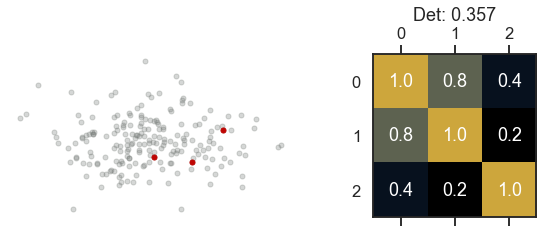

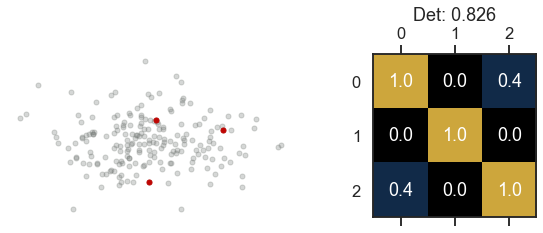

In [133]:
for sample in [[66, 1, 8], [3, 2, 8]]:
    
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 3), gridspec_kw={'width_ratios': [1.3, 1]})
    ax1.plot(X[:, 0], X[:, 1], '.', markersize=10, c=CLR['dgray'], alpha=0.3)
    ax1.plot(X[sample, 0], X[sample, 1], '.', c=CLR['red'], markersize=10)
    ax1.axis('off')
    utils.plot_kernel_with_values(L[sample, ...][:, sample], ax=ax2)